<a href="https://colab.research.google.com/github/haleelsada/MY-PROJECTS/blob/main/Binary_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


We have to folders with two class of images we make a model to classify a new image to any of these classes

**Importing** **Libraries**

In [19]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

#for image preprocessing
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split

#for evaluating score(error) of model
from sklearn.metrics import confusion_matrix

In [20]:
#i think we are switching to gpu
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


**Loading available data**

In [21]:
path = r'/content/drive/MyDrive/AI Workshop-20210619T014534Z-001/AI Workshop/w2'

data = pd.DataFrame(columns=["class_label","img_path"])

#os listdir gives all file names in the given path
#in path there is two files each contain a class of images, we have to itterate through both one by one
for class_label in os.listdir(path):
  for pic_image_path in os.listdir(os.path.join(path,class_label)):
    img_path = path+'/'+class_label+'/'+pic_image_path
#if file is an image add it's path name to img_path column in dataframe and add that folder name(class name) to class_label column
    if img_path.endswith('.jpg') or img_path.endswith('.JPEG') or img_path.endswith('.png') or img_path.endswith('.JPG'):
      data = data.append({'class_label':class_label,'img_path':img_path}, ignore_index=True)


In [22]:
min_req = 50
for class_ in data['class_label'].unique():
  if len(data[data['class_label']==class_]) < min_req:
    print(class_)
    data = data[data['class_label'] != class_]

data = data.sample(frac=1,random_state=1)
data.dropna(inplace=True)
data.reset_index(drop=True,inplace=True)
data.tail()

,class_label,img_path
438,Mohanlal,/content/drive/MyDrive/AI Workshop-20210619T01...
439,Mammootty,/content/drive/MyDrive/AI Workshop-20210619T01...
440,Mohanlal,/content/drive/MyDrive/AI Workshop-20210619T01...
441,Mammootty,/content/drive/MyDrive/AI Workshop-20210619T01...
442,Mammootty,/content/drive/MyDrive/AI Workshop-20210619T01...


In [23]:
train_df,test_df = train_test_split(data, test_size = 0.20,random_state=1)
IMG_HEIGHT, IMG_WIDTH, CHANNELS = 224,224,3

batch_size=20
#some preprocessing function ig
train_datagen =  image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range =5,
    shear_range = 0.1,
    zoom_range = 0.1,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True



)
# now we have to link the path in dataframe to real images we use flow_from_dataframe function under ImageDataGenerator
# instead of features and labels here both are stored in the train generator itself
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col = 'img_path',
    y_col = 'class_label',
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = batch_size,
)
# do same for testdata also
test_datagen = image.ImageDataGenerator(
    rescale = 1./255
)

val_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col = 'img_path',
    y_col = 'class_label',
    target_size = (IMG_HEIGHT,IMG_WIDTH),
    batch_size = batch_size,
)

Found 354 validated image filenames belonging to 2 classes.
Found 89 validated image filenames belonging to 2 classes.


In [24]:
class_names = list(train_generator.class_indices.keys())
NUM_CLASS = len(class_names)
dict_ = {'class_names':class_names}
print(dict_)

{'class_names': ['Mammootty', 'Mohanlal']}


In [25]:
bincount = np.bincount(train_generator.classes)
weights = np.round(train_generator.n/(NUM_CLASS*bincount),decimals=3)
class_weights = dict(zip([i for i in range(NUM_CLASS)],weights))
print(class_weights)

{0: 0.868, 1: 1.18}


In [26]:
# i didn't understand this part much
# we're loading a pretrained model and using it as primary layer to our model
def get_model(input_shape,num_class,summary=True):
  base_model = tf.keras.applications.ResNet50V2(
      input_shape= input_shape,
      include_top=False,
      weights='imagenet'
  )
  base_model.trainable = True
  model = tf.keras.Sequential(
      [
       base_model,
       tf.keras.layers.GlobalAveragePooling2D(),
       tf.keras.layers.Dropout(0.2),
       tf.keras.layers.Dense(256,activation='relu'),
       tf.keras.layers.Dense(num_class,activation='softmax')
      ]
  )

  model.compile(
      tf.keras.optimizers.RMSprop(),
      tf.keras.losses.BinaryCrossentropy(),
      ['accuracy']
  )
  if summary: model.summary()
  return model
#functin to train model
def train_model(model,
                train_generator,
                val_generator,
                save_path,
                epochs=25,
                patience = 10,
                class_weight=None):
  early_stopping = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss',
      min_delta=0,
      patience=patience,
      verbose=1,
      mode='auto',
      restore_best_weights =True
  )
  check_pointer = tf.keras.callbacks.ModelCheckpoint(
      save_path,
      monitor='val_loss',
      verbose =1,
      save_best_only=True,
      save_weights_only=False,
      mode='auto',
      period=1
  )
  history = model.fit_generator(
      train_generator,
      epochs=epochs,
      class_weight=class_weight,
      validation_data = val_generator,
      callbacks=[early_stopping,check_pointer]
  )
  return history

In [27]:
#it difines a model and save wheights to the model in every few iterations
model_of_interest = 'mm_classifier.h5'
#call the model function
model = get_model((IMG_HEIGHT,IMG_WIDTH,CHANNELS),NUM_CLASS)
#call the function to train
history = train_model(
    model,
    train_generator,
    val_generator,
    save_path = model_of_interest,
    epochs = 30,
    patience = 10,
    class_weight=class_weights
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 7, 7, 2048)        23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 514       
Total params: 24,089,858
Trainable params: 24,044,418
Non-trainable params: 45,440
_________________________________________________________________
Epoch 1/30
18/18 [==============================] - 18s 587ms/step - loss: 0.8839 - accuracy: 0.4887 - 

In [41]:
#function to get sample output

def demo_results(model,image_path,class_names,target_size = (224,224,3),ground_truth=None):
  img = image.load_img(image_path,color_mode='rgb',target_size=target_size)
  img = image.img_to_array(img).astype('float32')/255.0
  class_ = np.argmax(model.predict(np.expand_dims(img,axis=0))[0],axis=-1)
  predicted_label = class_names[class_]
  plt.figure(figsize=(5,7))
  plt.title('Binary classification')
  plt.text(0,1.06*target_size[0],str('Prediction:' + predicted_label),fontsize=12,color='teal')
  if ground_truth is not None:
    col = 'red'*(predicted_label !=ground_truth) + 'green'*(predicted_label==ground_truth)
    plt.text(0,1.11*target_size[0],str('Actual:' +ground_truth), fontsize=12,color=col)
  plt.axis('off')
  plt.imshow(img)
  plt.show()

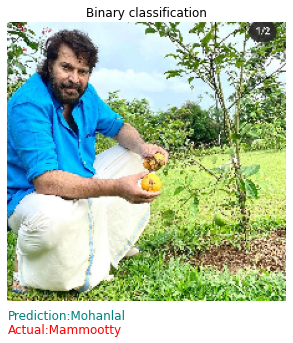

In [42]:
#sample output
test_id = np.random.randint(0,val_generator.n)
img_path = val_generator.filenames[test_id]
true_label = class_names[val_generator.classes[test_id]]
demo_results(model,img_path,class_names,ground_truth=true_label)